In [ ]:
#from google.colab import drive

#drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import pandas as pd
# print("Hello")

import matplotlib.pyplot as plt
import seaborn as sns

# Deschidere doc. excel
#df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Econometrie_avansata_proiect/Baza de date.xlsx')

ModuleNotFoundError: No module named 'pandas'

In [ ]:
# Previzualizare date
print("----- Primele 5 rânduri -----")
print(df.head())

# Informații despre tipurile de date
print("\n----- Info despre dataframe -----")
print(df.info())

# Verificare valori lipsă
print("\n----- Valori lipsă pe coloană -----")
print(df.isnull().sum())

# Statistici descriptive
print("\n----- Statistici descriptive pentru variabile numerice -----")
print(df.describe())

----- Primele 5 rânduri -----
                       Tara  AccesElectricitate%   Populatie  NrNasteri  \
0               South Sudan                  7.7  40000412.0  1453685.0   
1                   Burundi                 10.2   2811666.0    29955.0   
2                      Chad                 11.3  44761099.0   957511.0   
3                    Malawi                 14.2     78364.0      535.0   
4  Central African Republic                 15.7     92349.0     1121.0   

   Natalitate_(pop/nr.nasteri)  HumanDevelopmentIndex(HDI)   \
0                     3.634175                        0.478   
1                     1.065383                        0.796   
2                     2.139159                        0.745   
3                     0.682711                        0.858   
4                     1.213873                        0.788   

   LifeExpectancyAtBirth  ExpectedYearsOfSchooling  
0                   62.0                      10.3  
1                   76.0          

## **1) Observăm că există valori lipsă**

Pentru tratarea problemei valorilor lipsă, grupăm țările în funcție de HDI. Țările cu un indice al dezvoltării umane asemănător au de obicei valori similare pentru restul variabilelor

In [ ]:
# 1. Creare grupe după HDI

def clasificare_HDI(hdi):
    if hdi >= 0.8:
        return 'ridicat'
    elif hdi >= 0.65:
        return 'mediu'
    else:
        return 'scazut'

df['Nivel_dezvoltare'] = df['HumanDevelopmentIndex(HDI) '].apply(clasificare_HDI)

In [ ]:
# 2. Imputarea medianei pe grupuri

for col in ['AccesElectricitate%', 'Populatie', 'NrNasteri', 'LifeExpectancyAtBirth', 'ExpectedYearsOfSchooling']:
    df[col] = df.groupby('Nivel_dezvoltare')[col].transform(lambda x: x.fillna(x.median()))

In [ ]:
# 3. Verificăm dacă mai există valori lipsă
print("\n----- Valori lipsă pe coloană -----")
print(df.isnull().sum())


----- Valori lipsă pe coloană -----
Tara                           0
AccesElectricitate%            0
Populatie                      0
NrNasteri                      0
Natalitate_(pop/nr.nasteri)    0
HumanDevelopmentIndex(HDI)     1
LifeExpectancyAtBirth          0
ExpectedYearsOfSchooling       0
Nivel_dezvoltare               0
dtype: int64


Din moment ce acum există o singură valoare lipsă în întreaga bază de date, o putem elimina, deoarece această observație nu are un impact puternic asupra analizei noastre.

In [ ]:
df = df.dropna(subset=['HumanDevelopmentIndex(HDI) '])

# Verificăm dacă mai există valori lipsă
print("\n----- Valori lipsă pe coloană -----")
print(df.isnull().sum())


----- Valori lipsă pe coloană -----
Tara                           0
AccesElectricitate%            0
Populatie                      0
NrNasteri                      0
Natalitate_(pop/nr.nasteri)    0
HumanDevelopmentIndex(HDI)     0
LifeExpectancyAtBirth          0
ExpectedYearsOfSchooling       0
Nivel_dezvoltare               0
dtype: int64


## Continuăm analiza descriptivă

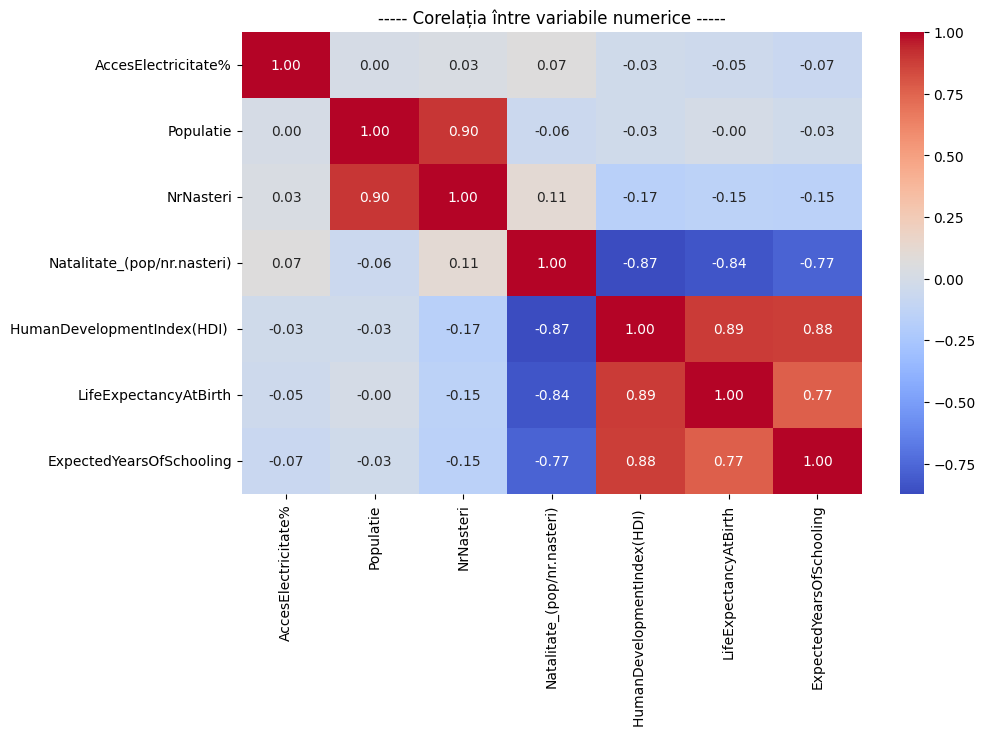

In [ ]:
# Matrice de corelație (numerice)
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("----- Corelația între variabile numerice -----")
plt.show()

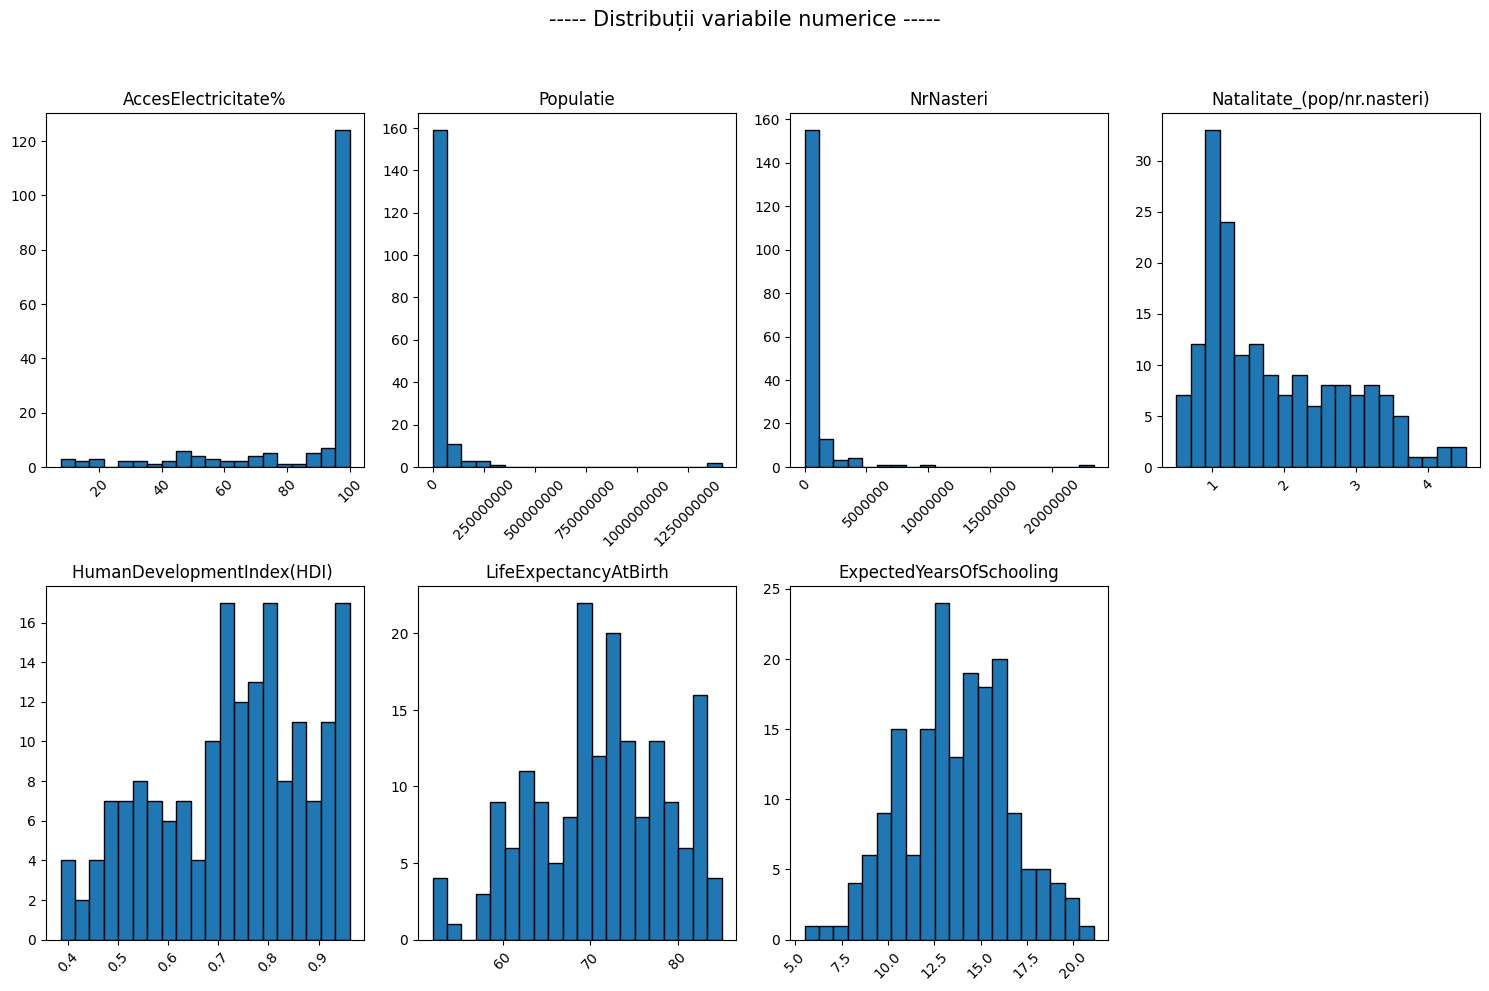

In [ ]:
# Histogramă pentru fiecare variabilă numerică

numeric_cols = df.select_dtypes(include=['float64']).columns
num_cols = len(numeric_cols)
cols = 4  # câte coloane de subploturi
rows = (num_cols + cols - 1) // cols  # câte rânduri sunt necesare

plt.figure(figsize=(15, 10))

for i, col in enumerate(numeric_cols, 1):
    ax = plt.subplot(rows, cols, i)
    ax.hist(df[col].dropna(), bins=20, edgecolor='black')
    ax.set_title(col)

    # Axa x: scoate notația științifică
    ax.ticklabel_format(style='plain', axis='x')
    ax.tick_params(axis='x', rotation=45)  # opțional: rotește etichetele dacă sunt lungi

plt.suptitle("----- Distribuții variabile numerice -----", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## 2) Observăm outlieri în cazul variabilelor *Populație* și *NrNasteri*

Am ales să rezolvăm problema valorilor aberante folosind logaritmarea

<ipython-input-57-4b69817e0df2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Populatie_log'] = np.log1p(df['Populatie'])  # log(1 + x)


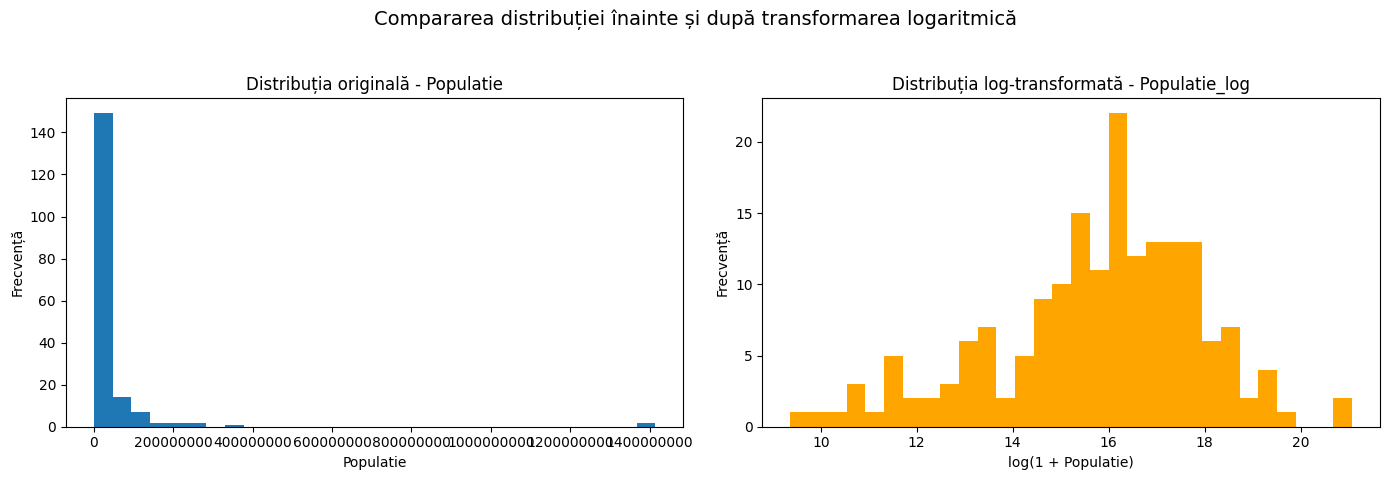

In [ ]:
# Prelucrarea datelor din Populație

import numpy as np

df['Populatie_log'] = np.log1p(df['Populatie'])  # log(1 + x)

# Creăm graficele pentru a observa cum s-a schimbat distribuția valorilor
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Histograma originală
axs[0].hist(df['Populatie'].dropna(), bins=30)
axs[0].set_title("Distribuția originală - Populatie")
axs[0].set_xlabel("Populatie")
axs[0].set_ylabel("Frecvență")
axs[0].ticklabel_format(style='plain', axis='x')  # scoate notatia 1e6

# Histograma transformată
axs[1].hist(df['Populatie_log'].dropna(), bins=30, color='orange')
axs[1].set_title("Distribuția log-transformată - Populatie_log")
axs[1].set_xlabel("log(1 + Populatie)")
axs[1].set_ylabel("Frecvență")

plt.suptitle("Compararea distribuției înainte și după transformarea logaritmică", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


<ipython-input-58-01e24fbe1506>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NrNasteri_log'] = np.log1p(df['NrNasteri'])  # log(1 + x)


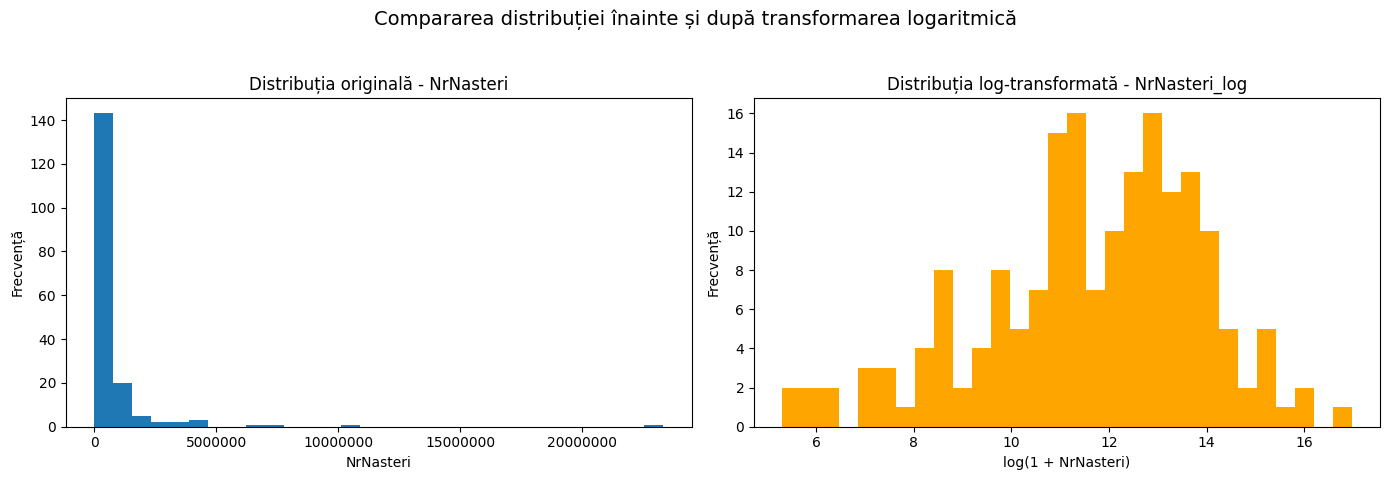

In [ ]:
# Prelucrarea datelor din NrNasteri

df['NrNasteri_log'] = np.log1p(df['NrNasteri'])  # log(1 + x)

# Creăm graficele pentru a observa cum s-a schimbat distribuția valorilor
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Histograma originală
axs[0].hist(df['NrNasteri'].dropna(), bins=30)
axs[0].set_title("Distribuția originală - NrNasteri")
axs[0].set_xlabel("NrNasteri")
axs[0].set_ylabel("Frecvență")
axs[0].ticklabel_format(style='plain', axis='x')  # scoate notatia 1e6

# Histograma transformată
axs[1].hist(df['NrNasteri_log'].dropna(), bins=30, color='orange')
axs[1].set_title("Distribuția log-transformată - NrNasteri_log")
axs[1].set_xlabel("log(1 + NrNasteri)")
axs[1].set_ylabel("Frecvență")

plt.suptitle("Compararea distribuției înainte și după transformarea logaritmică", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## **Estimarea unui model de regresie liniară clasică**

Alegem ca variabile explicative rata populației cu acces la electricitate, populația (valoarea logaritmată), numărul de nașteri (valoarea logaritmată), speranța de viață, numărul așteptat de ani de școlarizare. Nu includem variabilele *natalitate* și *nivel de dezvoltare*, acestea fiind derivate din populație și numărul de nașteri, respectiv derivată din HDI

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

In [ ]:
# Selectarea variabilelor explicative
X = df[['AccesElectricitate%', 'Populatie_log', 'NrNasteri_log',
        'LifeExpectancyAtBirth', 'ExpectedYearsOfSchooling']]

# Variabila dependentă
y = df['HumanDevelopmentIndex(HDI) ']

In [ ]:
# Analiza statistică a modelului de regresie liniară clasică OLS
X_const = sm.add_constant(X)
ols_model = sm.OLS(y, X_const).fit()
print("\nRezumat statsmodels:")
print(ols_model.summary())


Rezumat statsmodels:
                                 OLS Regression Results                                
Dep. Variable:     HumanDevelopmentIndex(HDI)    R-squared:                       0.900
Model:                                     OLS   Adj. R-squared:                  0.897
Method:                          Least Squares   F-statistic:                     312.2
Date:                         Sat, 24 May 2025   Prob (F-statistic):           1.36e-84
Time:                                 15:27:31   Log-Likelihood:                 290.23
No. Observations:                          179   AIC:                            -568.5
Df Residuals:                              173   BIC:                            -549.3
Df Model:                                    5                                         
Covariance Type:                     nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----

În urma aplicării modelului OLS pe setul nostru de date, obținem un R-squared = 0.9 și Prob (F-statistic) = 1.36e-84, ceea ce arată o calitate crescută a modelului.

Cu excepția variabilei AccesElectricitate%, toate celelalte variabile explicative sunt semnificative statistic pentru un prag de 0.05, așadar variabila menționată poate fi exclusă din modelul OLS.

De asemenea, valoarea testului Durbin-Watson = 2.037 (foarte apropiată de 2) arată că reziduurile nu sunt autocorelate. Trebuie ținut cont și de faptul că reziduurile nu sunt distribuite normal (testul Jarque-Bera are o valoare foarte crescută)

Refacem modelul, de această dată fără variabila AccesElectricitate%

In [ ]:
# Noua selecție de variabile explicative (fără AccesElectricitate%)
X_nou = df[['Populatie_log', 'NrNasteri_log', 'LifeExpectancyAtBirth', 'ExpectedYearsOfSchooling']]
y_nou = df['HumanDevelopmentIndex(HDI) ']  # ținta rămâne aceeași

# Analiza statistică a modelului de regresie liniară clasică OLS
X_const_nou = sm.add_constant(X_nou)
ols_model_nou = sm.OLS(y_nou, X_const_nou).fit()
print("\nRezumat statsmodels:")
print(ols_model_nou.summary())


Rezumat statsmodels:
                                 OLS Regression Results                                
Dep. Variable:     HumanDevelopmentIndex(HDI)    R-squared:                       0.899
Model:                                     OLS   Adj. R-squared:                  0.896
Method:                          Least Squares   F-statistic:                     385.2
Date:                         Sat, 24 May 2025   Prob (F-statistic):           2.80e-85
Time:                                 15:57:04   Log-Likelihood:                 288.71
No. Observations:                          179   AIC:                            -567.4
Df Residuals:                              174   BIC:                            -551.5
Df Model:                                    4                                         
Covariance Type:                     nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----

Putem observa că eliminarea variabilei AccesElectricitate% a îmbunătățit interpretabilitatea modelului fără a-i reduce performanța. Toate cele 4 variabile explicative sunt acum semnificative statistic

## **Estimarea unui model de regresie liniară prin învățare supervizată**

In [ ]:
# Împărțirea în set de antrenare și test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelul de regresie
model = LinearRegression()
model.fit(X_train, y_train)

# Predicții
y_pred = model.predict(X_test)

In [ ]:
# Evaluare
print("R² score:", r2_score(y_test, y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

R² score: 0.8263544284017901
RMSE: 0.07031312315143137


Valoarea lui R-squared arată faptul că modelul explică 82,6% din variația indicelui de dezvoltare umană.


Comparăm performanța testului de antrenare cu cea a setului de test:

In [ ]:
# Scor pe setul de antrenare
y_train_pred = model.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

print("Train R²:", r2_train)
print("Train RMSE:", rmse_train)

Train R²: 0.9209699992137806
Train RMSE: 0.041148764078695166


Se observă o diferență de aproape 0,1 între R-squared pentru setul de antrenare și cel de test, iar valorile pentru RMSE nu diferă nici ele semnificativ, ceea ce indică faptul că nu este prezent cazul de overfitting.

In [ ]:
# Coeficienți
coef_df = pd.DataFrame({
    'Variabilă': X.columns,
    'Coeficient': model.coef_
})
print("\nCoeficienți:")
print(coef_df)


Coeficienți:
                  Variabilă  Coeficient
0       AccesElectricitate%    0.000167
1             Populatie_log    0.054705
2             NrNasteri_log   -0.056915
3     LifeExpectancyAtBirth    0.007691
4  ExpectedYearsOfSchooling    0.022876


In [ ]:
# Statistici descriptive
print("\n----- Statistici descriptive pentru variabile numerice -----")
print(df.describe())


----- Statistici descriptive pentru variabile numerice -----
       AccesElectricitate%     Populatie     NrNasteri  \
count           179.000000  1.790000e+02  1.790000e+02   
mean             86.858659  4.317826e+07  7.227376e+05   
std              24.112498  1.542822e+08  2.129477e+06   
min               7.700000  1.170900e+04  2.020000e+02   
25%              88.350000  2.453176e+06  3.406500e+04   
50%             100.000000  9.709891e+06  1.531970e+05   
75%             100.000000  3.124609e+07  5.963925e+05   
max             100.000000  1.414204e+09  2.332185e+07   

       Natalitate_(pop/nr.nasteri)  HumanDevelopmentIndex(HDI)   \
count                   179.000000                   179.000000   
mean                      1.858334                     0.729777   
std                       0.964531                     0.151823   
min                       0.500874                     0.385000   
25%                       1.048355                     0.616500   
50%          

# Regresia polinomială

Vom folosi termeni polinomiali și interacțiuni între variabile pentru a captura relații non-lineare între predictori și variabila țintă.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
# Pregătirea datelor
X = df[['Populatie_log', 'NrNasteri_log', 'LifeExpectancyAtBirth', 'ExpectedYearsOfSchooling']]
y = df['HumanDevelopmentIndex(HDI) ']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Construirea modelului polinomial grad 2
degree = 2
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Antrenarea modelului
poly_model.fit(X_train, y_train)

# Predicții
y_pred = poly_model.predict(X_test)

In [ ]:
# Evaluare
print(f"R² score: {r2_score(y_test, y_pred):.4f}")

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

R² score: 0.7874
RMSE: 0.0778


R-squared pentru regresia liniară simplă (0.9) este mai mare decât cel obținut folosind regresia polinomială (0.787)

# Random Forest

Random Forest este un model non-liniar, robust și des folosit pentru regresiile cu mai multe variabile explicative, pentru a captura relații complexe.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
# Datele selectate
X = df[['Populatie_log', 'NrNasteri_log', 'LifeExpectancyAtBirth', 'ExpectedYearsOfSchooling']]
y = df['HumanDevelopmentIndex(HDI) ']

# Împărțirea datelor în train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Definirea modelului Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Antrenarea modelului
rf.fit(X_train, y_train)

# Predicții pe test
y_pred = rf.predict(X_test)

In [ ]:
# Evaluarea modelului
print(f"R² score: {r2_score(y_test, y_pred):.4f}")

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

R² score: 0.7768
RMSE: 0.0797


# Feature Selection

Pentru a îmbunătăți performanța modelelor și a obține o reprezentare mai relevantă a relației dintre variabilele explicative și indicele de dezvoltare umană (HDI), am explorat două abordări complementare:

1. Eliminarea variabilelor informativ slabe

Am aplicat Regresia Lasso pentru a identifica cele mai importante variabile explicative. Acest model penalizează coeficienții irelevanți, împingându-i spre zero, ajutând astfel la selecția caracteristicilor relevante.

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# Standardizare
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Lasso cu cross-validation
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)

# Coeficienți
selected_features = pd.Series(lasso.coef_, index=X.columns)
print(selected_features)

Populatie_log               0.092790
NrNasteri_log              -0.109205
LifeExpectancyAtBirth       0.062663
ExpectedYearsOfSchooling    0.064646
dtype: float64


2. Crearea de variabile noi (Feature Engineering)
Am creat o variabilă derivată, deja prezentă în set, dar ignorată anterior:

Natalitate relativă = Populație / Număr nașteri (notată Natalitate_(pop/nr.nasteri))

Aceasta exprimă o măsură inversă a ratei natalității, oferind o perspectivă interesantă asupra demografiei.

Am testat un model Random Forest folosind doar aceste trei variabile

In [ ]:
X_fs = df[['Natalitate_(pop/nr.nasteri)', 'LifeExpectancyAtBirth', 'ExpectedYearsOfSchooling']]
y_fs = df['HumanDevelopmentIndex(HDI) ']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_fs, y_fs, test_size=0.2, random_state=42)

# Model
rf_fs = RandomForestRegressor(random_state=42)
rf_fs.fit(X_train, y_train)
y_pred = rf_fs.predict(X_test)

# Evaluare
print(f"R²: {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {mean_squared_error(y_test, y_pred)**0.5:.4f}")


R²: 0.8187
RMSE: 0.0718


In [ ]:
# Statistici descriptive
print("\n----- Statistici descriptive pentru variabile numerice -----")
print(df.describe())


----- Statistici descriptive pentru variabile numerice -----
       AccesElectricitate%     Populatie     NrNasteri  \
count           179.000000  1.790000e+02  1.790000e+02   
mean             86.858659  4.317826e+07  7.227376e+05   
std              24.112498  1.542822e+08  2.129477e+06   
min               7.700000  1.170900e+04  2.020000e+02   
25%              88.350000  2.453176e+06  3.406500e+04   
50%             100.000000  9.709891e+06  1.531970e+05   
75%             100.000000  3.124609e+07  5.963925e+05   
max             100.000000  1.414204e+09  2.332185e+07   

       Natalitate_(pop/nr.nasteri)  HumanDevelopmentIndex(HDI)   \
count                   179.000000                   179.000000   
mean                      1.858334                     0.729777   
std                       0.964531                     0.151823   
min                       0.500874                     0.385000   
25%                       1.048355                     0.616500   
50%          

  OLS_0:
R-squared = 0.9
Prob (F-statistic) = 385.2
DW = 1.999
JB = 671.969


  Regresie liniara - supervizat antrenare:
R-squared = 0.826
RMSE = 0.0703

  Regresie liniara - supervizat test:
R-squared = 0.921
RMSE = 0.0411

  Regresia polinomială:
R² score: 0.7874  RMSE: 0.0778

  Random forest:
R² score: 0.7768
RMSE: 0.0797